In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

## 1. Data Acquisition


In [49]:
df = pd.read_csv("train.csv")
num_rows, num_cols = df.shape
print("Rows: ", num_rows)
print("Columns: ", num_cols)

Rows:  252175
Columns:  91


In [63]:
display(df.describe())
display(df.info())
display(df.head())

,Year,S0,S1,S2,S3,S4,S5,S6,S7,S8,...,S80,S81,S82,S83,S84,S85,S86,S87,S88,S89
count,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,...,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000,252123.000000
mean,1998.350143,43.379082,1.554115,8.644903,1.160495,-6.526296,-9.531860,-2.367001,-1.788615,3.712732,...,15.724619,-73.286196,41.487949,38.044051,0.334009,17.931321,-26.509443,4.488371,19.873068,1.309111
std,10.497821,6.066799,51.553786,35.236419,16.336976,22.842798,12.809783,14.531206,7.963667,10.554074,...,31.984394,174.926010,122.250505,94.579907,16.021250,114.048957,173.685614,13.286652,185.161556,22.113446
min,1956.000000,3.455260,-334.953220,-301.005060,-149.962040,-181.953370,-72.717370,-111.017810,-68.404510,-119.762620,...,-437.722030,-2984.920970,-1810.689190,-1848.702260,-272.289050,-2343.894110,-3819.933620,-233.456480,-7458.378150,-286.031200
25%,1994.000000,39.959190,-25.652865,-11.525215,-8.492365,-20.588825,-18.403075,-10.770910,-6.473035,-2.296255,...,-1.788015,-139.031800,-21.015265,-4.631245,-6.749575,-31.247580,-102.179795,-2.536405,-59.734690,-8.819860
50%,2002.000000,44.250210,8.654700,10.517340,-0.641620,-5.998880,-11.189760,-2.072920,-1.727880,3.821940,...,9.132190,-53.171760,28.675010,33.593230,0.818240,15.846730,-21.623440,3.145800,7.775050,0.062890
75%,2006.000000,47.823030,36.250215,29.795445,8.767810,7.740135,-2.448085,6.512805,2.913495,9.938115,...,26.208285,13.413625,89.185855,77.879375,8.451960,67.776985,51.887175,9.999690,85.829385,9.651235
max,2009.000000,61.970140,384.065730,318.868960,228.412110,262.068870,166.236890,160.815220,82.942190,92.792850,...,840.973380,4469.454870,3210.701700,1734.079690,199.121500,3662.065650,2833.608950,275.353660,7240.653730,600.766240


<class 'pandas.core.frame.DataFrame'>
Int64Index: 252123 entries, 0 to 252174
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Year    252123 non-null  int64  
 1   S0      252123 non-null  float64
 2   S1      252123 non-null  float64
 3   S2      252123 non-null  float64
 4   S3      252123 non-null  float64
 5   S4      252123 non-null  float64
 6   S5      252123 non-null  float64
 7   S6      252123 non-null  float64
 8   S7      252123 non-null  float64
 9   S8      252123 non-null  float64
 10  S9      252123 non-null  float64
 11  S10     252123 non-null  float64
 12  S11     252123 non-null  float64
 13  S12     252123 non-null  float64
 14  S13     252123 non-null  float64
 15  S14     252123 non-null  float64
 16  S15     252123 non-null  float64
 17  S16     252123 non-null  float64
 18  S17     252123 non-null  float64
 19  S18     252123 non-null  float64
 20  S19     252123 non-null  float64
 21  S20     25

None

,Year,S0,S1,S2,S3,S4,S5,S6,S7,S8,...,S80,S81,S82,S83,S84,S85,S86,S87,S88,S89
0,2007,44.76752,114.82099,3.83239,27.99928,1.49153,-15.90853,28.24844,3.61650,-7.24653,...,-1.89619,-471.02844,411.56205,443.01198,19.30254,309.07806,-336.91706,-14.70547,-474.44157,31.32820
1,2004,52.28942,75.73319,11.35941,-6.20582,-27.64559,-30.75995,12.50955,7.47877,9.88498,...,4.57060,1.36110,-6.52977,59.48672,3.69790,-36.92252,44.08077,3.39993,-70.07591,3.86143
2,2005,33.81773,-139.07371,134.19332,17.85216,63.47408,-25.28005,-34.65911,-5.99135,1.27848,...,54.16608,15.04530,39.09107,39.03041,3.68708,-61.88547,45.68115,6.39822,3.24471,35.74749
3,1998,41.60866,3.17811,-3.97174,23.53564,-19.68553,20.74407,18.80866,6.24474,-7.98424,...,28.08591,295.88684,54.02395,102.02880,40.47711,15.10258,-250.32293,2.81288,56.05172,3.60432
4,1987,44.49525,-32.25270,58.08217,3.73684,-32.53274,-18.72885,-15.85665,-3.34607,22.63786,...,31.44988,-136.50457,-85.11989,-74.96342,9.56921,-100.61689,-133.29315,9.19246,-97.37953,30.11015


### Data Cleaning


In [61]:
print("Null rows:", df.shape[0] - df.dropna().shape[0])
print("Duplicated rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Null rows: 0
Duplicated rows: 52


## 2. Data Visualization


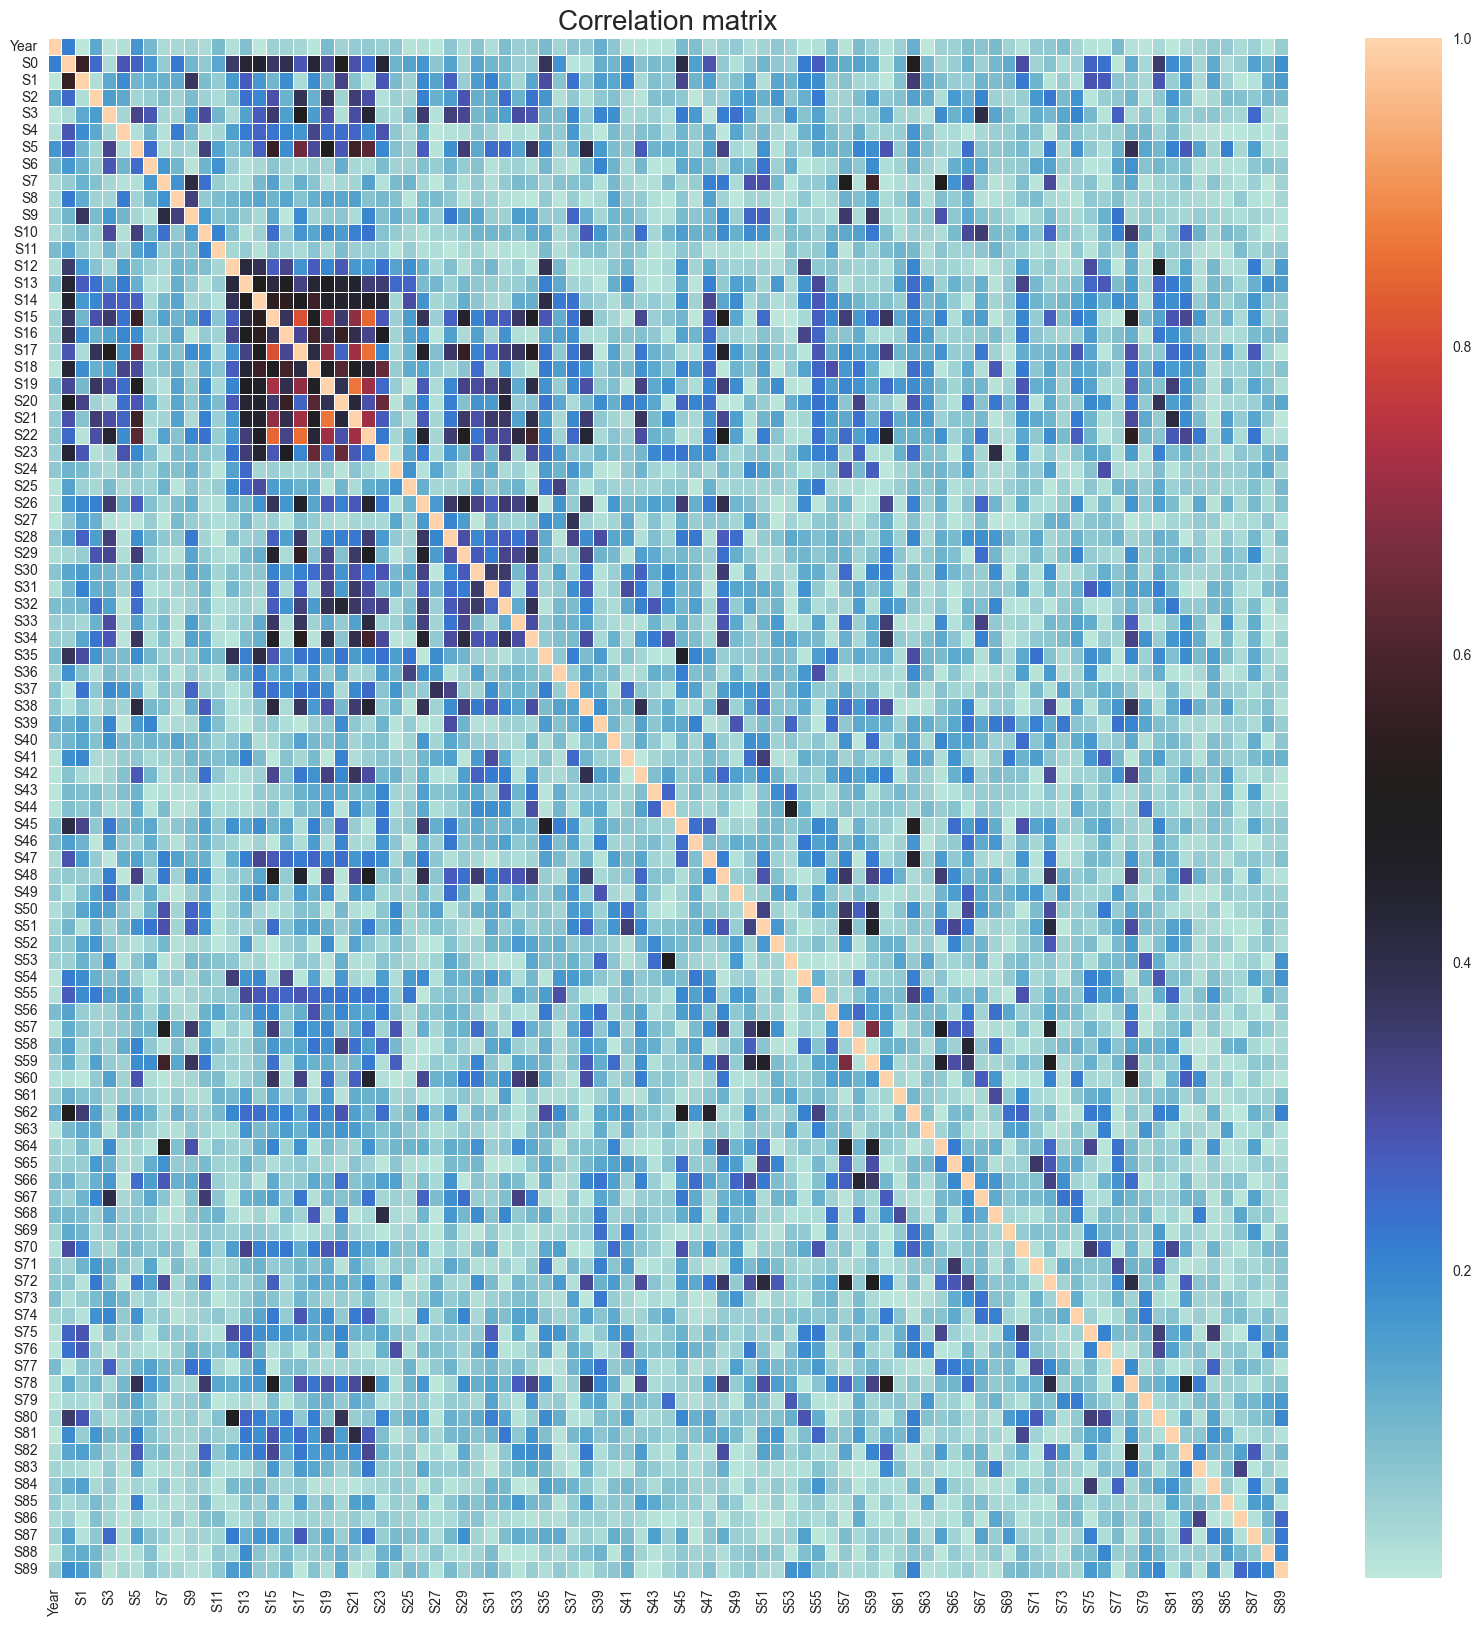

In [145]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr().abs(), cmap="icefire", linewidths=0.5)
plt.title("Correlation matrix", fontsize=20)
plt.xticks(rotation=90)
plt.show()

The dataset shows a low degree of correlation among its various features. However, a closer examination of the top-left quadrant reveals a cluster of variables exhibiting stronger correlation. A zoomed-in view of this region is provided below for further analysis.


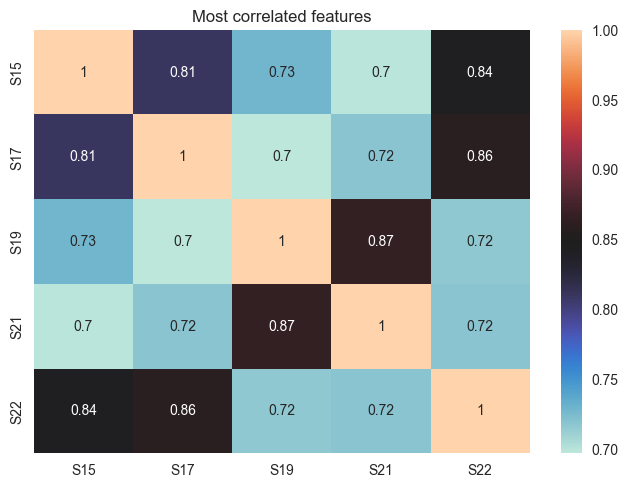

In [149]:
corr = df.corr().abs()
corr.replace(1, -10, inplace=True)
corr = corr[corr.max(axis=1) > 0.8]
corr.replace(-10, 1, inplace=True)
corr.drop(corr.columns.difference(corr.index), axis=1, inplace=True)

sns.heatmap(corr, cmap="icefire", annot=True)
plt.yticks(rotation=90)
plt.title("Most correlated features")
plt.show()

C:\Users\Win10\AppData\Local\Temp\ipykernel_7984\3967910576.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr["Year"], y=corr.index, palette="icefire")


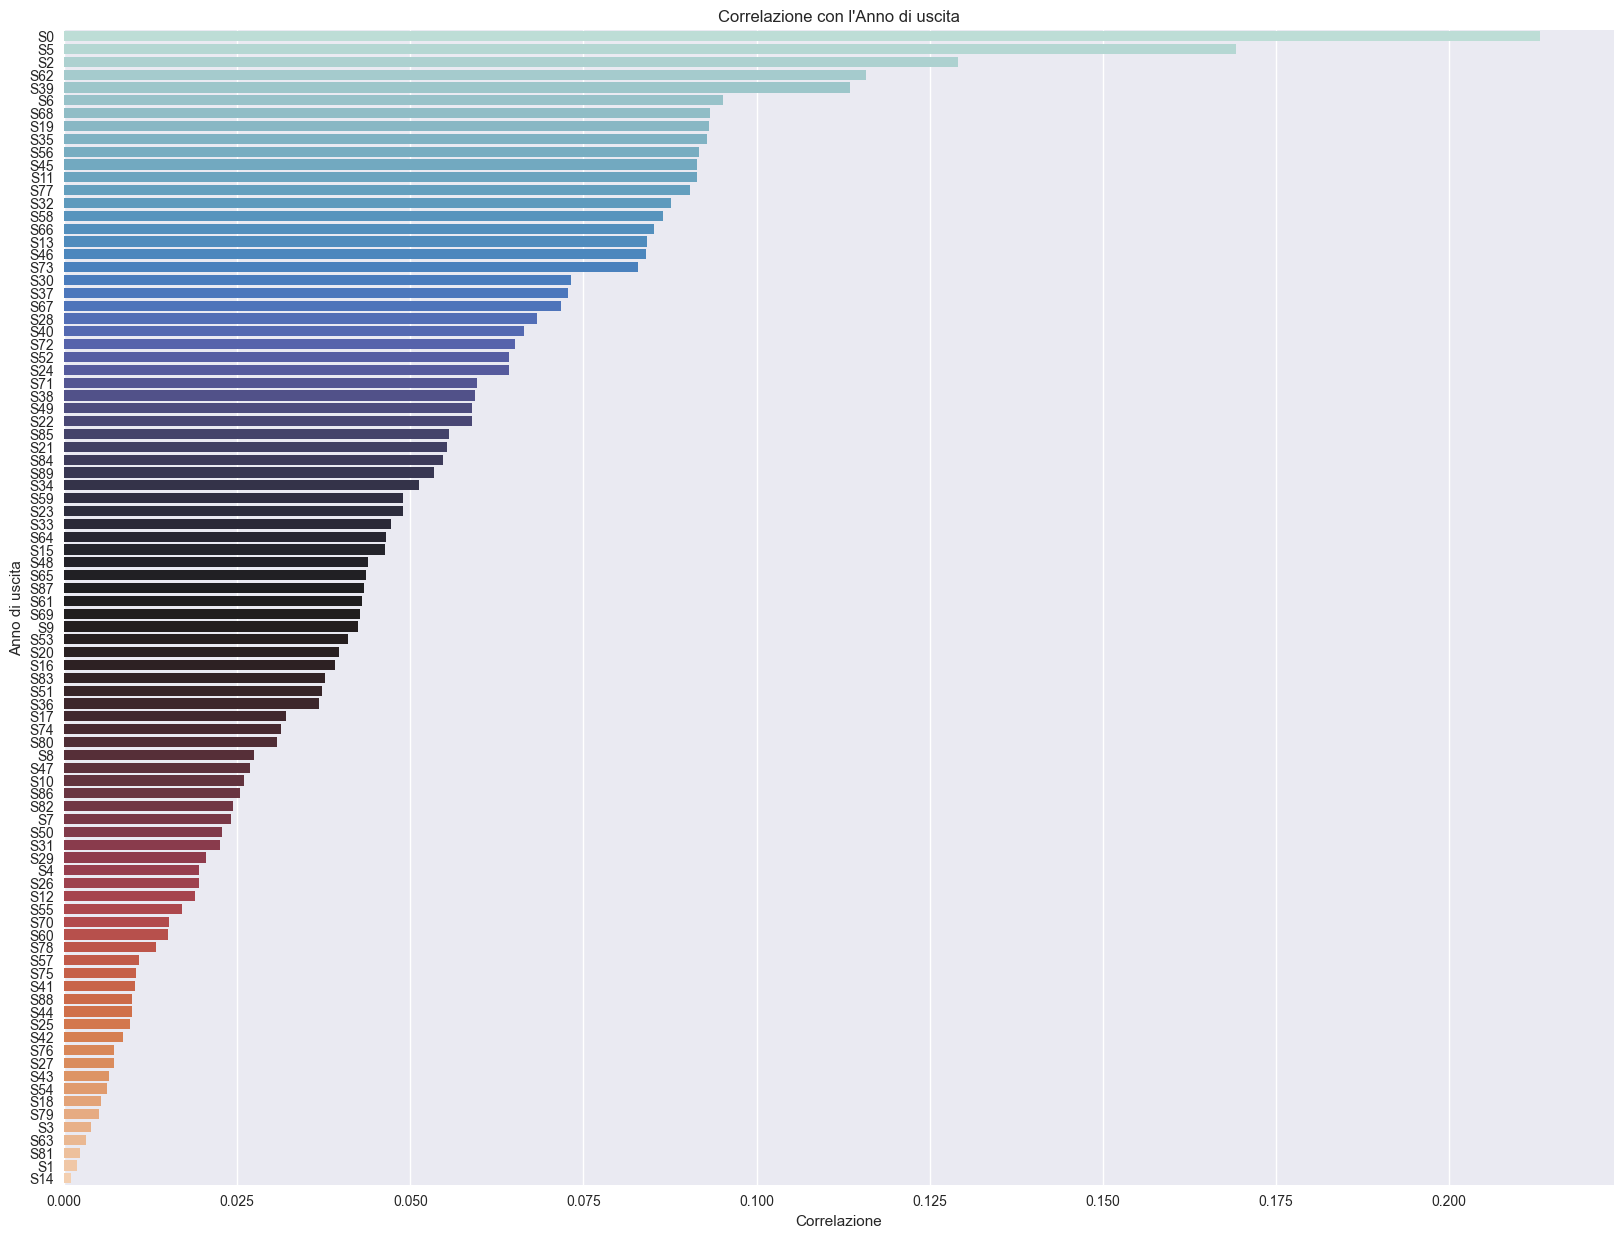

In [117]:
# calculate the correlation and sort by Year
corr = df.corr().abs()
corr.sort_values(by=["Year"], ascending=False, inplace=True)
corr = corr[1:]

# plot the correlation with barplot
plt.figure(figsize=(20, 15))
sns.barplot(x=corr["Year"], y=corr.index, palette="icefire")
plt.xlabel("Correlation")
plt.ylabel("Year")
plt.title("Correlation with Year", fontsize=20)
plt.show()

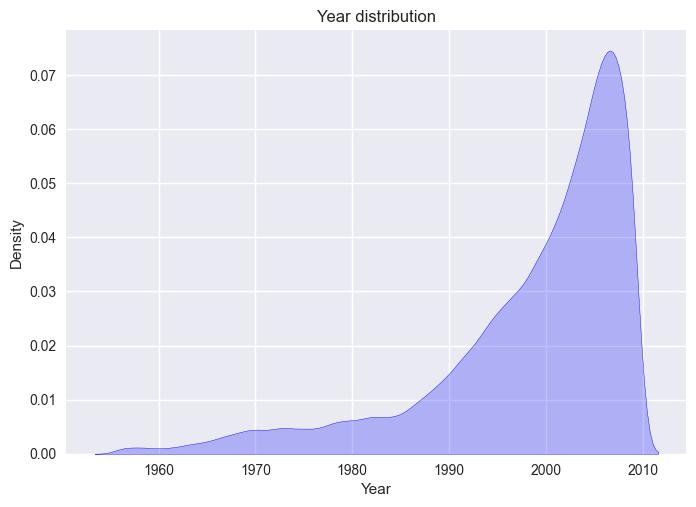

In [150]:
plt.title("Year distribution")
sns.kdeplot(data=df["Year"], fill=True, color="b")
plt.show()

In [116]:
display(
    pd.DataFrame(
        [df.Year.mean(), df.Year.median(), int(df.Year.mode()), df.Year.std()],
        index=["Mean", "Median", "Mode", "Std deviation"],
        columns=["Value"],
    )
)

,Value
Mean,1998.350143
Median,2002.000000
Mode,2007.000000
Std deviation,10.497821


KeyboardInterrupt: 

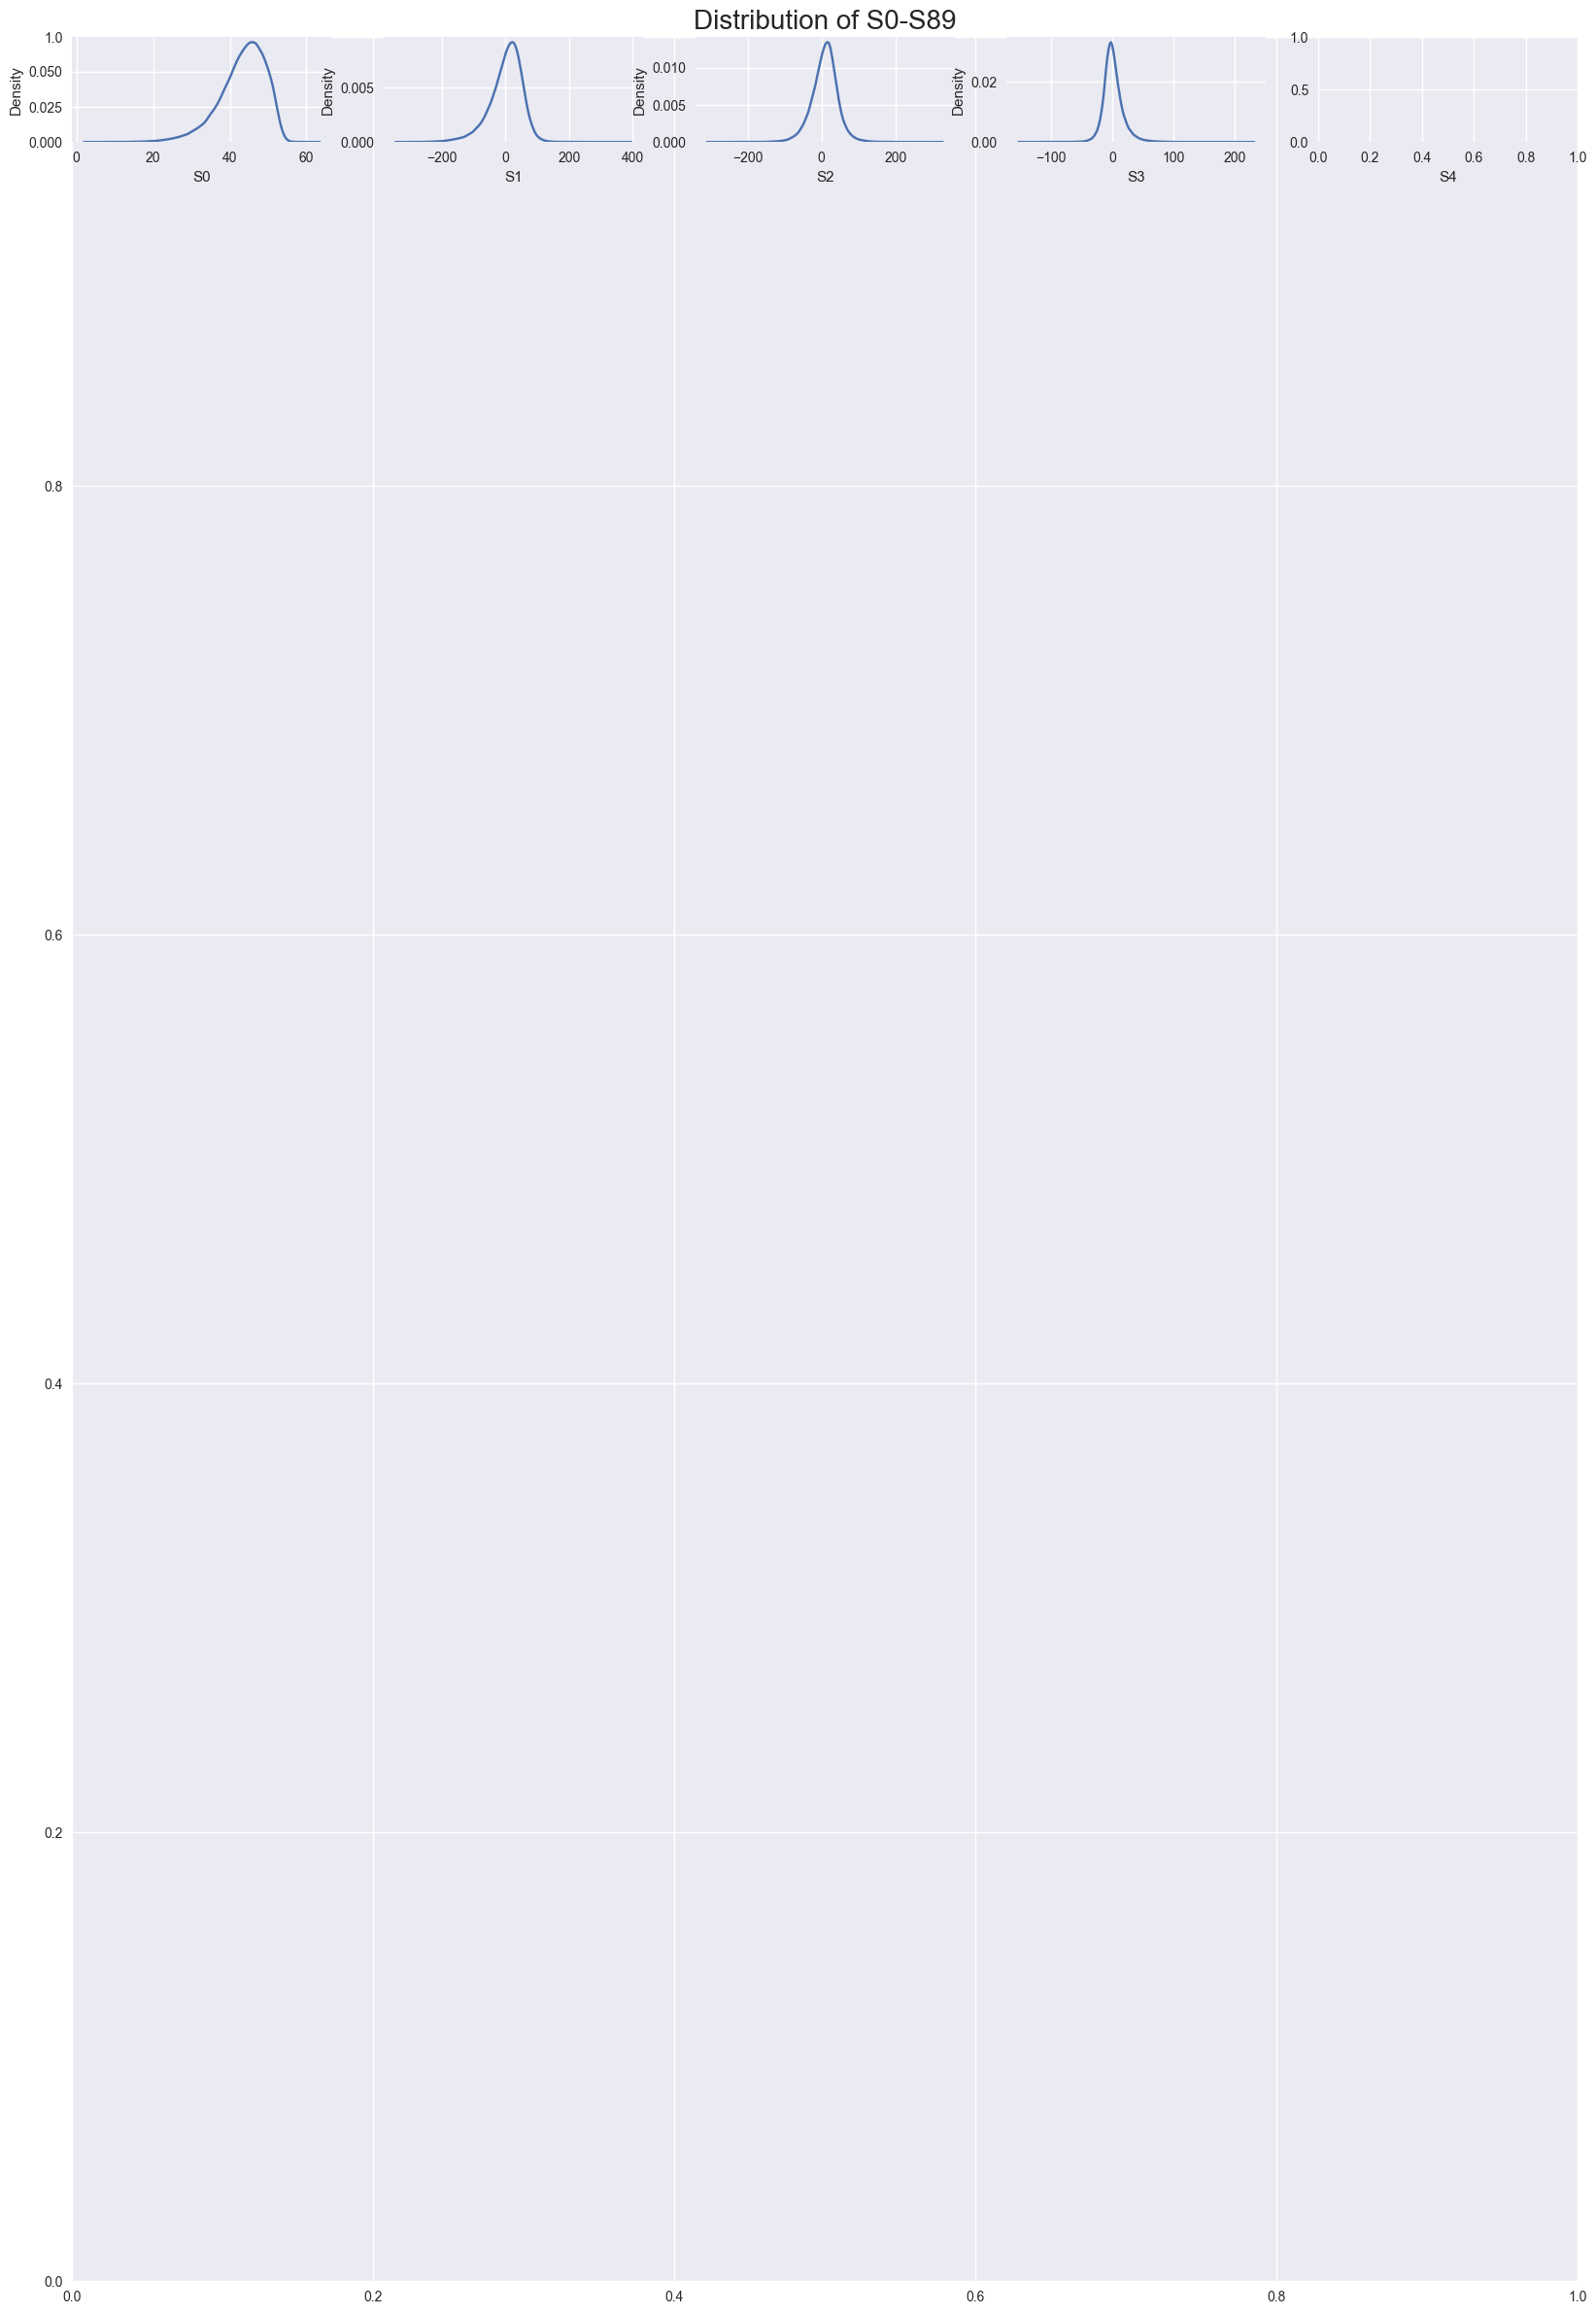

In [ ]:
pos = 1
plt.figure(figsize=(20, 30))
plt.title("Distribution of S0-S89", fontsize=20)
for col in df.columns[1:]:
    plt.subplot(18, 5, pos)
    plt.xlabel(col)
    sns.kdeplot(df[col])
    pos = pos + 1

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

for p in [5, 30, 50, 100]:
    tsne = TSNE(n_components=2, init="random", random_state=42, perplexity=p)
    tsne.fit(X)
    X_t = tsne.fit_transform(X)
    plt.scatter(X_t[:, 0], X_t[:, 1], c=y)
    plt.title(p)
    plt.show()

All the attributes show a Gaussian distribution with different skew, all with median in 0 except for the attribute `S0`.


---

## Modeling

#### con Data Pre-Processing per ogni modello

### Linear Regression


In [66]:
random_state = 42

In [231]:
from sklearn.model_selection import train_test_split

df_X = df.iloc[:, 1:]
df_y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.33, random_state=random_state)

In [234]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor

param_estimator = {}

# step_name, [(transformer_name, transformer_constructor()), ...], step_param_grid
transformers = [
    ("raw", [("raw", "passthrough")], {}),  # does nothing to the data
    ("std-scaled", [("std-scale", preprocessing.StandardScaler())], {}),
    ("min-maxed", [("min-max", preprocessing.MinMaxScaler())], {}),
    (
        "min-max + pca",
        [("min-max", preprocessing.MinMaxScaler()), ("pca", PCA(random_state=random_state))],
        {
            "pca__svd_solver": ["auto", "full"],
            "pca__n_components": ["mle"],
            "pca__whiten": [True, False],
        },
    ),
    (
        "lda",
        [("lda", LinearDiscriminantAnalysis())],
        {
            "lda__solver": ["svd", "eigen"],
        },
    ),
]

best_estimators = {}

# For every preprocess modality
for name_step, transformer, param_grid in transformers:
    pipe = Pipeline([*transformer, ("lr", RandomForestRegressor(n_jobs=-1))])
    gs = GridSearchCV(pipe, param_grid={**param_estimator, **param_grid}, n_jobs=-1, cv=3)

    gs.fit(X_train.values, y_train)

    best_estimators[name_step] = gs.best_estimator_

    print("{} data. Params: {}. Accuracy: {}".format(name_step, gs.best_params_, gs.score(X_test.values, y_test)))

KeyboardInterrupt: 

In [210]:
len(best_estimators["pca"][0].explained_variance_)

89